In [1]:
import torch
import pandas as pd
import numpy as np

In [2]:
df_train = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")

In [3]:
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
X, y = df_train.drop(columns=["label"], axis=1), df_train['label']

In [8]:
f"X shape: {X.shape}; y shape: {y.shape}"

'X shape: (42000, 784); y shape: (42000,)'

In [29]:
from torch.utils.data import Dataset, SubsetRandomSampler
from PIL import Image

class DigitDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.dataframe = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        data = self.dataframe.iloc[idx, 1:].values
        data = data.reshape((28, 28))
        data = np.asarray(data, np.uint8)
        data = Image.fromarray(data, mode='L')
        target = self.dataframe.iloc[idx, 0]

        if self.transform:
            data = self.transform(data)

        return data, target

In [30]:
from torchvision import transforms

train_dataset = DigitDataset(
    "/kaggle/input/digit-recognizer/train.csv",
    transform=transforms.ToTensor(),
    
)

In [31]:
batch_size = 128

data_size = len(train_dataset)
validation_fraction = 0.2

val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))

np.random.seed(42)
np.random.shuffle(indices)

val_indices, train_indices = indices[:val_split], indices[val_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=train_sampler
)

val_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=val_sampler
)

In [32]:
device = torch.device("cuda:0") 

In [42]:
def train_model(model, train_loader, val_loader, optimizer, loss, scheduler, num_epochs):
    loss_history = []
    train_history = []
    val_history = []
    
    for epoch in range(num_epochs):
        model.train()
        
        loss_accum = 0.0
        correct_samples = 0
        total_samples = 0
        
        for idx, (X, y) in enumerate(train_loader):
            X_gpu = X.to(device)
            y_gpu = y.to(device)
            
            preds = model(X_gpu)
            loss_value = loss(preds, y_gpu)
            
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(preds, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value
            
        ave_loss = loss_accum / idx
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        scheduler.step(ave_loss)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
    
    
def compute_accuracy(model, val_loader):
    model.eval()
    
    correct_samples = 0
    total_samples = 0
    
    for idx, (X, y) in enumerate(val_loader):
        X_gpu = X.to(device)
        y_gpu = y.to(device)
        
        preds = model(X_gpu)
        
        _, indices = torch.max(preds, 1)
        correct_samples += torch.sum(indices == y_gpu)
        total_samples += y_gpu.shape[0]
        
    return float(correct_samples) / total_samples

In [69]:
from torch import nn
from torch import optim

model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3),
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(num_features=3),
    nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(num_features=6),
    
    nn.MaxPool2d(kernel_size=2),
    
    nn.Conv2d(in_channels=6, out_channels=10, kernel_size=3),
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(num_features=10),
    nn.Conv2d(in_channels=10, out_channels=14, kernel_size=3),
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(num_features=14),
    
    nn.Flatten(),
    nn.Linear(686, 10)
)

model.type(torch.cuda.FloatTensor)
model = model.to(device)

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5, verbose=True)

In [70]:
loss_history, train_history, val_history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss=loss,
    scheduler=scheduler,
    num_epochs=20
)

Average loss: 0.292434, Train accuracy: 0.918244, Val accuracy: 0.970476
Average loss: 0.082821, Train accuracy: 0.977500, Val accuracy: 0.978810
Average loss: 0.065054, Train accuracy: 0.983393, Val accuracy: 0.983690
Average loss: 0.057955, Train accuracy: 0.985685, Val accuracy: 0.985952
Average loss: 0.054744, Train accuracy: 0.986429, Val accuracy: 0.987381
Average loss: 0.051343, Train accuracy: 0.988214, Val accuracy: 0.988810
Average loss: 0.049953, Train accuracy: 0.987649, Val accuracy: 0.987024
Average loss: 0.049994, Train accuracy: 0.987530, Val accuracy: 0.987262
Average loss: 0.048327, Train accuracy: 0.988482, Val accuracy: 0.986429
Average loss: 0.048315, Train accuracy: 0.988333, Val accuracy: 0.985119
Average loss: 0.046676, Train accuracy: 0.988363, Val accuracy: 0.985833
Average loss: 0.045583, Train accuracy: 0.989196, Val accuracy: 0.986071
Average loss: 0.045982, Train accuracy: 0.989673, Val accuracy: 0.989048
Average loss: 0.045097, Train accuracy: 0.988958, V

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline

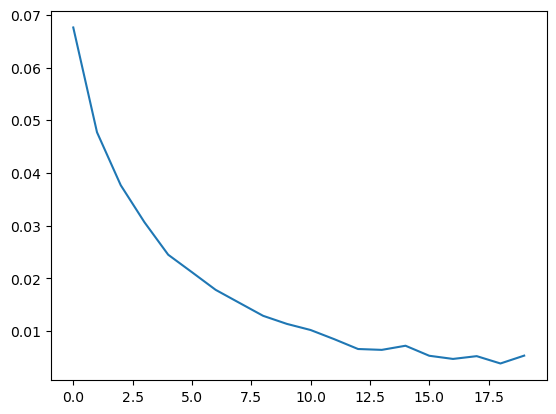

In [53]:
plt.plot(loss_history)

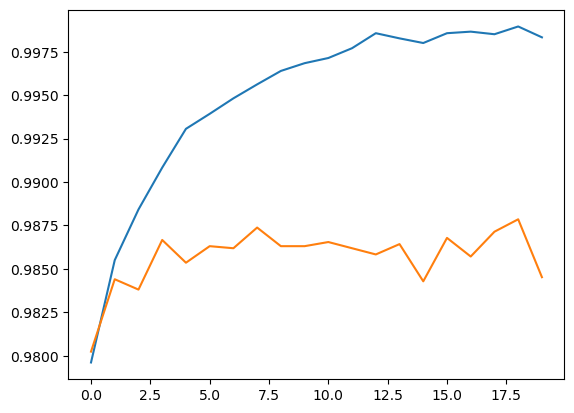

In [54]:
plt.plot(train_history)
plt.plot(val_history)

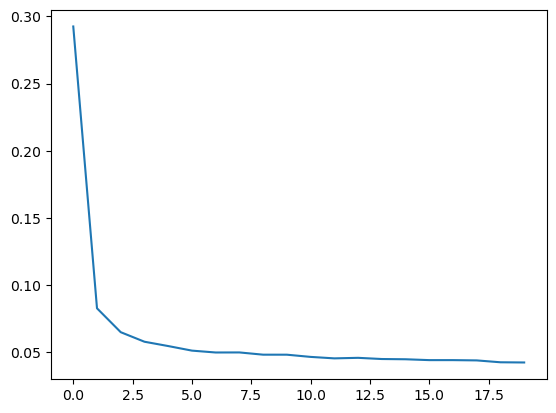

In [71]:
plt.plot(loss_history)

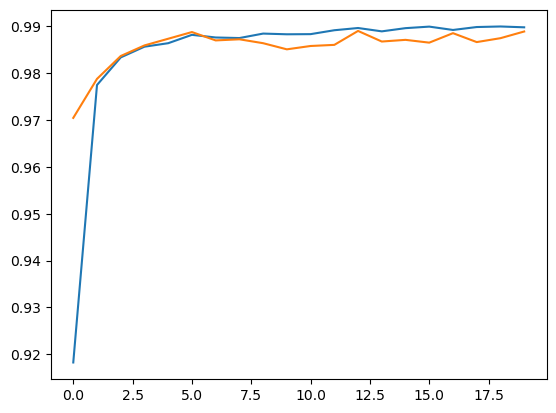

In [72]:
plt.plot(train_history)
plt.plot(val_history)

In [79]:
from torch.utils.data import Dataset, SubsetRandomSampler
from PIL import Image

class DigitDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.dataframe = pd.read_csv(csv_file)
        self.dataframe["tmp"] = 1
        self.transform = transform

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        data = self.dataframe.iloc[idx, 1:].values
        data = data.reshape((28, 28))
        data = np.asarray(data, np.uint8)
        data = Image.fromarray(data, mode='L')
        target = self.dataframe.iloc[idx, 0]

        if self.transform:
            data = self.transform(data)

        return data, target

In [84]:
test_dataset = DigitDataset(
    "/kaggle/input/digit-recognizer/test.csv",
    transform=transforms.ToTensor(),
)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)


model.eval()
    
correct_samples = 0
total_samples = 0

predicted_indices = []
    
for idx, (X, _) in enumerate(test_loader):
    X_gpu = X.to(device)

    preds = model(X_gpu)

    _, indices = torch.max(preds, 1)
    predicted_indices.extend([int(i) for i in indices])
    


In [86]:
result = pd.DataFrame()
result['ImageId'] = range(1, len(predicted_indices) + 1)
result['Label'] = predicted_indices

result.to_csv("submission_cnn.csv", index=False)